# SIR ODE Sensitivity and Uncertainty Analysis

This tutorial will cover the application of sensitivity and uncertainty methods on an SIR (Susceptible-Infectious-Recovered) compartmental model, composed of ordinary differential equations.

The purpose of an uncertainty analysis is to quantify how uncertainty in the model inputs propagates to uncertainty in the model outputs. It is *output focused*, so we are more so interested in quantifying the uncertainty of the model outputs.

A closely related concept is a sensitivity analysis, which quantifies our variation in each of our inputs causes the most variation in the model outputs. It is *input focused*, so we are interested in quantifying the identifying the model inputs that most greatly influence the outputs.

# Imports

We will first import all required dependencies.

In [1]:
import pandas as pd
import numpy as np
from calisim.example_models import SirOdesModel
import os.path as osp

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.sensitivity import (
	SensitivityAnalysisMethod,
	SensitivityAnalysisMethodModel,
)
from calisim.uncertainty import (
	UncertaintyAnalysisMethod,
	UncertaintyAnalysisMethodModel,
)
from calisim.statistics import MeanSquaredError

# Observed data

We will next load the observed field data.

In [6]:
model = SirOdesModel()
observed_data = model.get_observed_data()
observed_data

,dotS,dotI,dotR,day
0,999.000000,1.000000,0.000000,0
1,998.534208,1.349201,0.116592,1
2,997.906105,1.819995,0.273899,2
3,997.059813,2.454180,0.486007,3
4,995.919926,3.308098,0.771976,4
5,994.385263,4.457212,1.157524,5
6,992.323001,6.000336,1.676664,6
7,989.556810,8.068764,2.374426,7
8,985.847074,10.839686,3.313240,8
9,980.887285,14.538527,4.574189,9


In [9]:
reference_parameters = model.GROUND_TRUTH.copy()
reference_parameters

{'beta': 0.4, 'gamma': 0.1, 'N': 1000, 'I0': 1.0, 'R0': 0, 'S0': 999.0}

# Calibration procedure

## Uncertainty analysis

We will next run the calibration procedures against infection (dotI) data. In this case, we will start with an uncertainty analysis.

We begin by specifying our parameter distributions. We will calibrate 2 parameters:

- β (beta) = Infection rate: how fast the disease spreads (contact × transmission prob).
- γ (gamma) = Recovery rate: how fast people recover (≈ 1 / infectious period).

In [17]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="beta",
			distribution_name="uniform",
			distribution_args=[0.3, 0.5],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="gamma",
			distribution_name="uniform",
			distribution_args=[0.05, 0.15],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

We'll construct a function for our uncertainty analysis, which will return a vector of daily infections.

In [18]:
def uncertainty_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None, t: pd.Series
) -> float | list[float]:
    model = SirOdesModel()
    simulation_parameters = reference_parameters.copy()
    simulation_parameters["t"] = t
    
    for k in ["beta", "gamma"]:
        simulation_parameters[k] = parameters[k]
        
    simulated_data = model.simulate(simulation_parameters).dotI.values
    return simulated_data

[We next run the uncertainty analysis using the Chaospy library](https://chaospy.readthedocs.io/en/master/).

Chaospy will perform a Monte Carlo simulation as determined by the joint distribution of our parameter specification. It will then fit a polynomial chaos expansion (PCE) surrogate model that learns the relationship between the model inputs and outputs. More specifically, Polynomial Chaos Expansion (PCE) approximates a complex model 

$$
Y = f(X_1, X_2, \dots, X_n)
$$

as a polynomial of the uncertain inputs:

$$
Y \approx \sum_{i} c_i \, \Psi_i(X_1, X_2, \dots, X_n)
$$

where:  
- $X_1, X_2, \dots, X_n$ are the **uncertain input variables**.  
- $\Psi_i$ are **orthogonal polynomials** chosen according to the input distributions:  
  - Hermite polynomials for Normal distributions  
  - Legendre polynomials for Uniform distributions  
- $c_i$ are **coefficients** fitted from the model outputs.
- $i$ are the terms in the polynomial expansion.

A secondary benefit of surrogate modelling is that we speed up the uncertainty analysis by reducing the number of executions of the simulation model; our PCE model acts as a cheaper surrogate of the full model. [A more detailed tutorial on PCE can be found here](https://maths-people.anu.edu.au/~jakeman/QuantifyingUncertainty/Tutorials/PCtutorial.html).

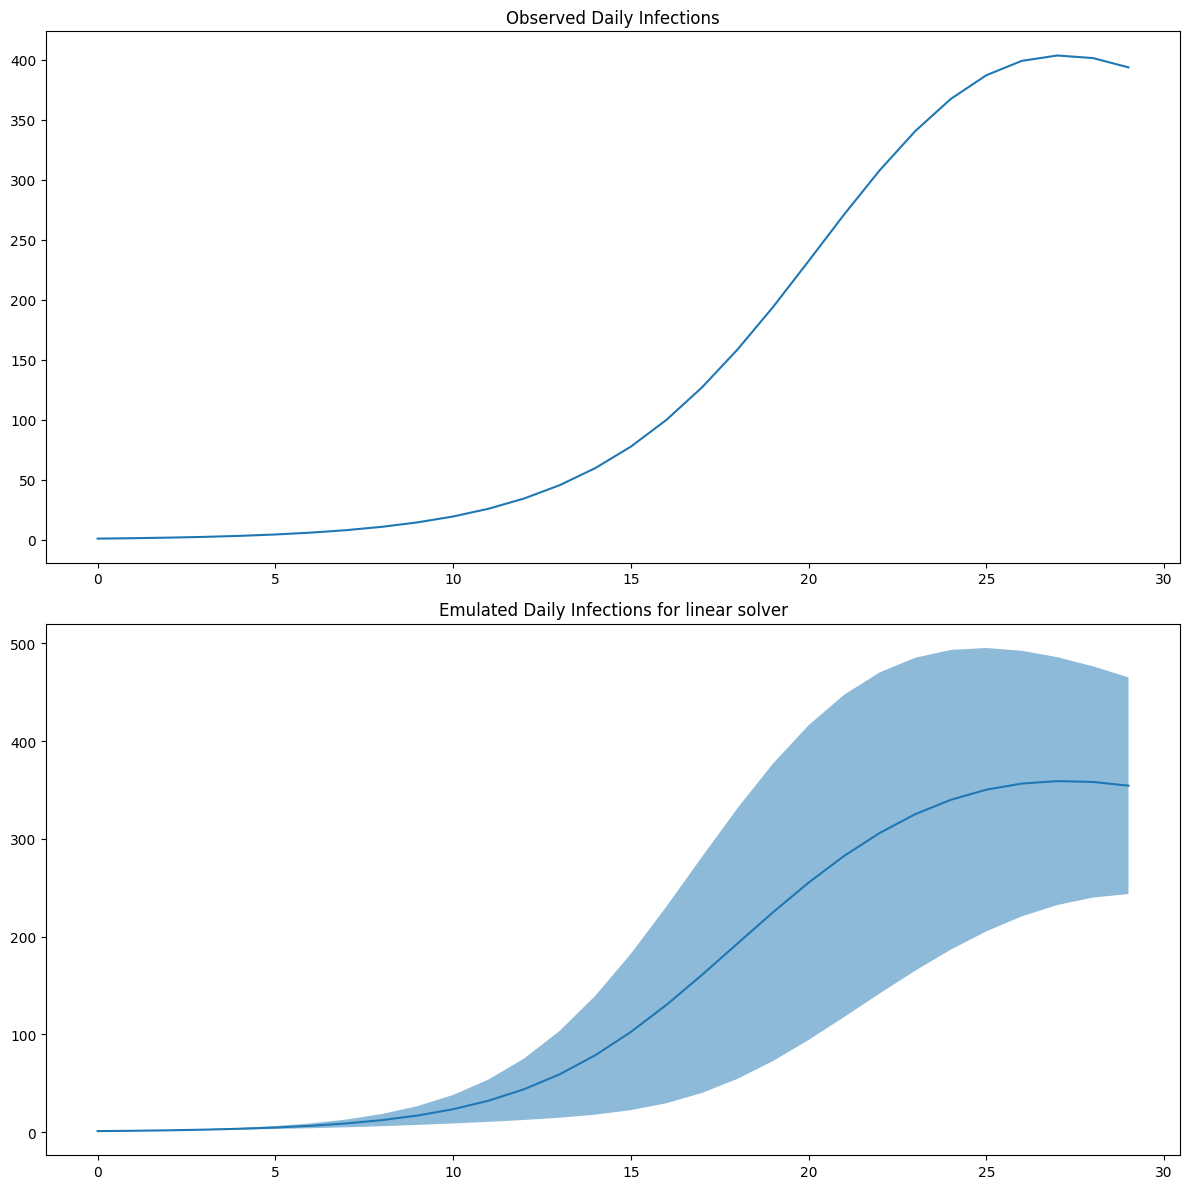

In [19]:
specification = UncertaintyAnalysisMethodModel(
	experiment_name="chaospy_uncertainty_analysis",
	parameter_spec=parameter_spec,
    observed_data=observed_data.dotI.values,
	solver="linear",
	algorithm="least_squares",
	method="sobol",
	order=2,
	n_samples=200,
	output_labels=["Daily Infections"],
	flatten_Y=True,
	batch=False,
	method_kwargs=dict(rule="cholesky", normed=False, cross_truncation=1.0),
    calibration_func_kwargs=dict(t=observed_data.day),
)

calibrator = UncertaintyAnalysisMethod(
	calibration_func=uncertainty_func, specification=specification, engine="chaospy"
)

calibrator.specify().execute().analyze()

We can see the results of the uncertainty analysis above. We have a deterministic and mechanistic ODE model, and by using a PCE surrogate model, we are able to construct a distribution of plausible trajectories for our simulated daily infections. We have the mean trajectory of our predicted infections, alongside its standard deviation.

An uncertainty analysis is particulary useful for both temporal and spatial modelling (in our case temporal), as it tracks how uncertainty in model inputs or conditions spreads and evolves across both space and time. It helps reveal where and when predictions are most reliable in dynamic, location-dependent systems.

## Sensitivity analysis

We will next perform a sensitivity analysis to derive sensitivity indices for our 2 parameters (beta and gamma). This will allow us to prioritise specific parameters for calibration using a combination of a data-driven approach (with our observed daily infections), consultation with domain experts, and a review of the available literature.

We will calculate Sobol sensitivity indices to quantify how the variation in the 2 input parameters of the model influences the variation in daily infections. [A detailed explaination of the Sobol methods may be found here.](https://link.springer.com/chapter/10.1007/978-3-030-51862-2_6). 

We'll first define a sensitivity analysis function which will return the discrepancy between observed and simulated daily infection values as determined by the mean squared error (MSE) metric. There are alternatives...we could return sensitivity indices for each time step if we wanted to perform a time-varying sensitivity analysis for instance. But we'll keep things simple.

In [21]:
def sensitivity_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None, t: pd.Series
) -> float | list[float]:
    model = SirOdesModel()
    simulation_parameters = reference_parameters.copy()
    simulation_parameters["t"] = t
    
    for k in ["beta", "gamma"]:
        simulation_parameters[k] = parameters[k]
        
    simulated_data = model.simulate(simulation_parameters).dotI.values
    metric = MeanSquaredError()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

[We'll use the Sobol method from the SALib library](https://salib.readthedocs.io/en/latest/), and take 250 base samples. We'll construct bootstrap confidence intervals for our sensitivity indices.

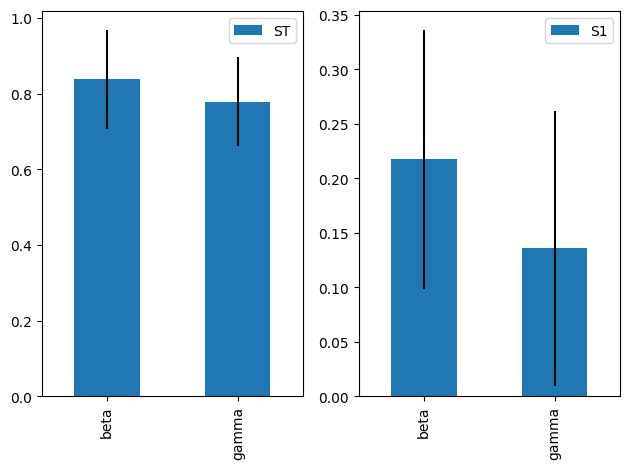

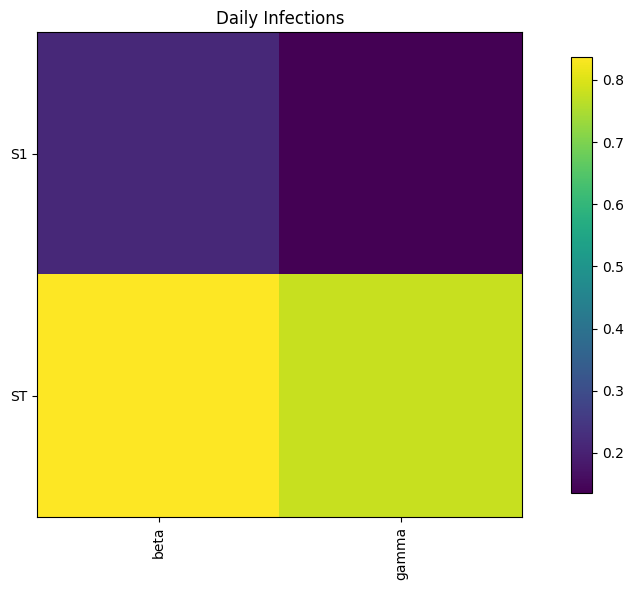

In [25]:
specification = SensitivityAnalysisMethodModel(
	experiment_name="salib_sensitivity_analysis",
	parameter_spec=parameter_spec,
    observed_data=observed_data.dotI.values,
	method="sobol",
	n_samples=500,
    n_jobs=1,
	output_labels=["Daily Infections"],
	verbose=True,
	batched=False,
	method_kwargs=dict(calc_second_order=False, scramble=True),
	analyze_kwargs=dict(
		calc_second_order=False,
		num_resamples=300,
		conf_level=0.95,
	),
    calibration_func_kwargs=dict(t=observed_data.day),
)

calibrator = SensitivityAnalysisMethod(
	calibration_func=sensitivity_func, specification=specification, engine="salib"
)

calibrator.specify().execute().analyze()

The variation in the discrepancy between simulated and observed daily infections data (the output) is most sensitive to variation in beta (the input), which is the infection rate: how fast the disease spreads (contact × transmission prob). Note that the bootstrap confidence intervals overlap, so it's possible that gamma is as influential if not more.

However, it appears that the varation in gamma has slightly less of an influence.

Hence, we would want to focus on calibrating beta first. To reduce the possibility of overfitting, we may hold less influential parameters, such as gamma, constant while varying more influential parameters such as beta.